# Plot and evaluate sample designs

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib as matplotlib
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import contextily as cx
# import rtree, pygeos, fiona
# import netCDF4
# import xarray as xr
# import dask

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = 'EPSG:3395'

In [3]:
# load coastlines (saved locally)
coast_fp = data_path / 'tufts-contuscoastline14-shapefile.zip'
boundary_fp = data_path / 'stanford-vg541kt0643-shapefile.zip'
coast = gpd.read_file(data_path / coast_fp).to_crs(geo_crs)
boundary = gpd.read_file(data_path / boundary_fp).to_crs(geo_crs)

In [4]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

# Create ocean boundaries

## Disks

In [5]:
# make disks
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)

## Rectangles

In [6]:
def get_bounding_box(lats, lons):
    geometry = []
    for i in lons:
        for j in lats:
            geometry += [Point(i,j)]
    geo = Polygon(geometry).envelope
    geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geo, crs=geo_crs))
    return geo
ca_box = get_bounding_box(ca_lats, ca_lons)
tx_box = get_bounding_box(tx_lats, tx_lons)
nh_box = get_bounding_box(nh_lats, nh_lons)

# Simple random sampling
Using rejection sampling. Here we scale up the number of target samples relative to the bounding box containing the sampling zone, then sample the entire bounding box, and reject any samples not in the sampling zone. It can be shown that the sample points are uniformly randomly distributed within our target sampling zone

In [45]:
def rejection_sample(n, region, desal_loc):
    # get fraction of sampling area
    sample_area = region.to_crs(proj_crs).area
    total_area = (gpd.GeoDataFrame(
            geometry=gpd.GeoSeries(
                Polygon([Point([region.bounds.minx, region.bounds.miny]), Point([region.bounds.minx, region.bounds.maxy]), 
                         Point([region.bounds.maxx, region.bounds.miny]), Point([region.bounds.maxx, region.bounds.maxy])]),
                crs=geo_crs).envelope).to_crs(proj_crs).area)
    pct_sample_area = sample_area / total_area
    
    # scale up target sample size to account for this
    n_scale = int(np.ceil(n / pct_sample_area))
    
    # generate lat lons
    lon = np.random.uniform(region.bounds.minx, region.bounds.maxx, n_scale)
    lat = np.random.uniform(region.bounds.miny, region.bounds.maxy, n_scale)
    geo = [Point(lat, lon) for lat, lon in zip(lon, lat)]
    geo_sub = [pt for pt in geo if region.contains(pt)[0]]
    print(f'Targeted {n} samples, {len(geo_sub)} returned ({len(geo_sub)-n})')
    
    # plot
    fig, ax = plt.subplots(figsize=(10,10))
    region.plot(ax=ax, alpha=0.5, label='sample zone')
    gpd.GeoSeries(geo_sub).plot(ax=ax, color='r', markersize=1.2, label='sample locations')
    desal_loc.plot(ax=ax, color='g', label='desal plant')
    plt.legend()
    
    return geo_sub

Targeted 200 samples, 201 returned (1)


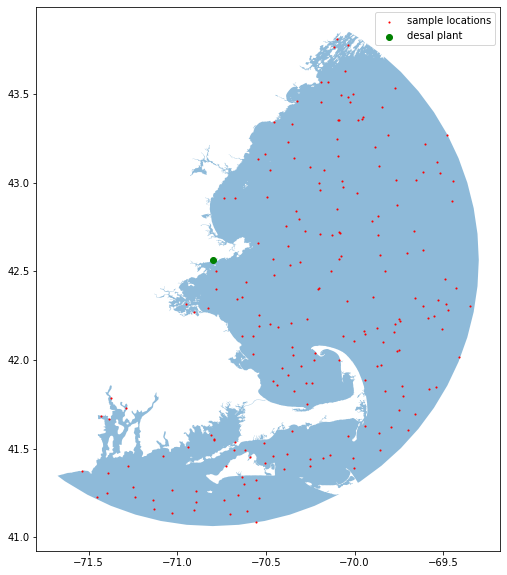

In [46]:
region = nh_disc.overlay(boundary, how='difference')
desal_loc = gpd.GeoSeries(Point(nh_cent))

nh = rejection_sample(200, region, desal_loc)

Targeted 200 samples, 201 returned (1)


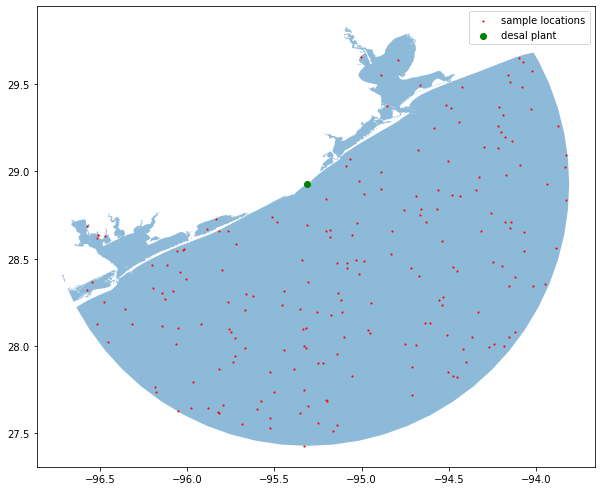

In [47]:
region = tx_disc.overlay(boundary, how='difference')
desal_loc = gpd.GeoSeries(Point(tx_cent))

tx = rejection_sample(200, region, desal_loc)

Targeted 200 samples, 200 returned (0)


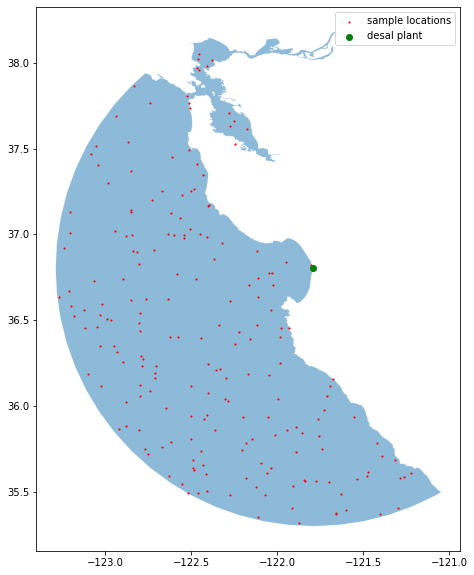

In [48]:
region = ca_disc.overlay(boundary, how='difference')
desal_loc = gpd.GeoSeries(Point(ca_cent))

ca = rejection_sample(200, region, desal_loc)

## Rectangles

<AxesSubplot:>

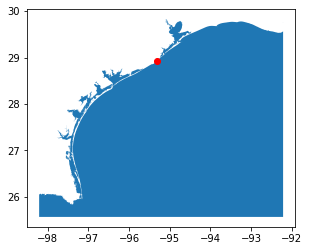

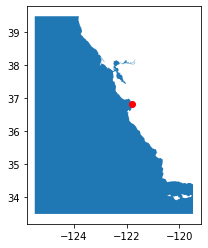

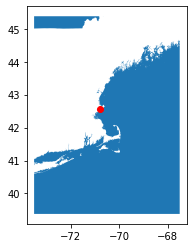

In [283]:
tx_ax=tx_box.overlay(boundary, how='difference').plot()
gpd.GeoSeries(Point(tx_cent), crs=geo_crs).plot(ax=tx_ax, color='r')
ca_ax=ca_box.overlay(boundary, how='difference').plot()
gpd.GeoSeries(Point(ca_cent), crs=geo_crs).plot(ax=ca_ax, color='r')
nh_ax=nh_box.overlay(boundary, how='difference').plot()
gpd.GeoSeries(Point(nh_cent), crs=geo_crs).plot(ax=nh_ax, color='r')